In [ ]:
# hide
# default_exp cli
from nbdev.showdoc import show_doc
from nbdev import *

# CLI

> The command line interface for the HECSS sampler

*Not implemented yet*

In [ ]:
# hide
# export
import click
from fastcore.script import Param, call_parse, bool_arg, store_true, store_false
from pathlib import Path
import os
import ase
from ase.calculators.vasp import Vasp
from ase import units as un
from hecss.core import *

In [ ]:
from hecss.monitor import plot_stats

In [ ]:
# export
def dfset_writer(s, sl, workdir=''):
    '''
    Just write samples to the DFSET.dat file in the workdir directory.
    '''
    wd = Path(workdir)
    write_dfset(f'{wd.joinpath("DFSET.dat")}', s)
    # Important! Return False to keep iteration going
    return False

In [ ]:
# export
@call_parse
def hecss_sampler(fname:  Param("Supercell structure file."
                                "The containing directory must be readable by Vasp(restart)."
                                , str),
                  workdir:Param("Output directory for samples", str)='calc', 
                  label:  Param("Job label passed to run-calc command", str)='hecss',
                  T:      Param("Target temperature (K)", float)=300,
                  width:  Param("Initial scale of the prior distribution", float)=1.0,
                  calc:   Param("Type of the calculator. Only VASP supported.", str)='VASP',
                  dfset:  Param("Write DFset file", store_false)=True, 
                  N:      Param("Number of samples", int)=10, 
                  cmd:    Param("Command for job submission", str)='./run-calc',
                  V:      Param("Print version and exit", store_true)=False):
    '''
    Run HECSS sampler on the structure passed in fname.
    '''

    if V:
        import hecss
        print(f'HECSS ver. {hecss.__version__}\n'
               'High Efficiency Configuration Space Sampler\n'
               '(C) 2021 by Paweł T. Jochym\n'
               '    License: GPL v3 or later')
        return

    
    print(f'Running HECSS on {fname}\n',
          f'Temperature:    {T}K\n',
          f'Work directory: {workdir}\n',
          f'Calculator:     {calc}.')
    
    src_path = Path(fname)
    
    print(src_path.parent, src_path.name)
    
    if calc=="VASP":
        calculator = Vasp(label=label, directory=src_path.parent, restart=True)
        cryst = ase.Atoms(calculator.atoms)
        cryst.set_calculator(calculator)
        calculator.set(directory=workdir)
        command = Path(cmd)
        calculator.set(command=f'{command.absolute()} {label}')
    else:
        print(f'The {calc} calculator is not supported.')
        return
    sentinel = None
    if dfset :
        sentinel = dfset_writer
    sampler = HECSS(cryst, calculator, T, directory=workdir, width=width)
    samples = sampler.generate(N, sentinel=sentinel, workdir=workdir)
    return samples

In [ ]:
# export
@click.command()
@click.argument('fname', type=click.Path(exists=True))            
@click.option('-W', '--workdir', default="WORK", type=click.Path(exists=True), help="Work directory")
@click.option('-l', '--label', default="hecss", help="Label for the calculations.")
@click.option('-T', '--temp', default=300, type=float, help="Target temperature in Kelvin.")
@click.option('-w', '--width', default=1.0, type=float, help="Initial scale of the prior distribution")
@click.option('-C', '--calc', default="VASP", type=str, 
              help="ASE calculator to be used for the job.\n" + "Supported calculators: VASP (default)")
@click.option('--dfset/--no-dfest', default=True, help='Write DFSET file for ALAMODE')
@click.option('-N', '--nsamples', default=10, type=int, help="Number of samples to be generated")
@click.option('-c', '--command', default='./run-calc', help="Command to run calculator")
def _hecss_sampler(fname, workdir, label, temp, width, calc, dfset, nsamples, command):
    '''
    Run HECSS sampler on the structure in the directory.
    fname - Supercell structure file. 
    The containing directory must be readable by Vasp(restart).
    '''
    return hecss_sampler(fname=fname, 
                         workdir=workdir, 
                         label=label, 
                         T=temp, 
                         width=width,
                         calc=calc, 
                         dfset=dfset, 
                         N=nsamples, 
                         cmd=command)

In [ ]:
# vasp
# slow
samples = hecss_sampler(fname="example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR", 
                        workdir='TMP', T=300, width=1.1, N=300)

Running HECSS on example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR
 Temperature:    300K
 Work directory: TMP
 Calculator:     VASP.
example/VASP_3C-SiC/1x1x1/sc_1x1x1 CONTCAR


0it [00:00, ?it/s]

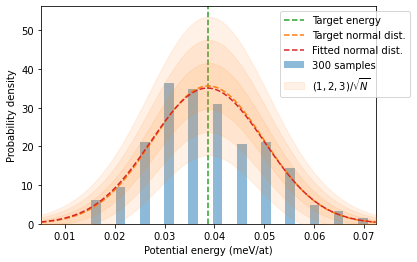

In [ ]:
# vasp
# slow
plot_stats(samples, 300)